This file combines degree of urbanaization with median income and vehicle ownership. \
mk-test dataframe is derived from the outout of Mann Kendall test on current population data. Output from: 1_mk_trend \
expected_trend_df dataframe is derived from the outout of Mann Kendall test on future population projections. Output from: 3_forecast_Trend 

In [1]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import chdir as cd
import time
import fiona
from datetime import date

C:\Users\uttar\AppData\Local\Temp\ipykernel_1384\2483259319.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Core-based Statistical Area (CBSA) Data

In [2]:
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_state.zip')
US_states = US_states.to_crs('EPSG:9311')

# adding metropolitan/Micropolitan geometry & population data
MSA_geo_20 = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_cbsa.zip')
MSA_geo_20 = MSA_geo_20.to_crs('EPSG:9311')
MSA_geo_20.columns

# CBSA to place area factors from GeoCorr2022 using population weights
cbsa_2_place_geocorr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\cbsa_2_place.csv', header=1, encoding='latin-1')

cbsa_2_place_geocorr['State code']  = cbsa_2_place_geocorr['State code'].astype(str).str.rjust(2,'0')
cbsa_2_place_geocorr['Place code']  = cbsa_2_place_geocorr['Place code'].astype(str).str.rjust(5,'0')
cbsa_2_place_geocorr['GEOID_place'] = cbsa_2_place_geocorr[['State code','Place code']].astype(str).agg(''.join, axis=1)
cbsa_2_place_geocorr['GEOID_cbsa']  = cbsa_2_place_geocorr['Core-based statistical area code'].astype(str)
cbsa_2_place_geocorr

cbsa_2_place = cbsa_2_place_geocorr[['GEOID_cbsa',  'cbsa20-to-place allocation factor', 'GEOID_place']]

# Adding commuting time for cbsa 
cbsa_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\ACSST5Y2020.S0801-Data.csv')
cbsa_tt = cbsa_commute_time[['GEO_ID', 'NAME', 'S0801_C01_046E']] # taking the column with mean travel time
cbsa_tt = cbsa_tt.tail(-1).reset_index(drop = True)
cbsa_tt['GEOID_cbsa'] = cbsa_tt['GEO_ID'].str[9:]
cbsa_tt.rename({'S0801_C01_046E':'tt_2_work'}, axis =1, inplace = True)
cbsa_tt

cbsa_data = cbsa_2_place.merge(cbsa_tt[['GEOID_cbsa', 'tt_2_work']], on = 'GEOID_cbsa', how = 'outer')
cbsa_2_place.shape, cbsa_tt.shape, cbsa_data.shape


cbsa_data['tt_2_work'] = cbsa_data['tt_2_work'].astype(float)
df_cbsa = cbsa_data.groupby('GEOID_place').agg({'GEOID_cbsa': 'count',
                                      'cbsa20-to-place allocation factor': 'sum',
                                      'tt_2_work': 'max'}).reset_index()

In [3]:
cbsa_data[cbsa_data['GEOID_place'].duplicated(keep = False)].sort_values(['GEOID_place']) #.nunique()

,GEOID_cbsa,cbsa20-to-place allocation factor,GEOID_place,tt_2_work
7924,23460,0.0088,0101660,25.0
2269,13820,0.0000,0101660,26.8
324,10700,0.0864,0102116,24.6
5544,18980,0.0003,0102116,26.0
325,10700,0.0922,0107912,24.6
...,...,...,...,...
12769,32420,0.2876,7299999,23.0
24705,49500,0.5396,7299999,23.7
10174,27580,0.7927,7299999,22.8
20336,41900,0.6039,7299999,25.8


# Urbanized area data

In [4]:
# urban area from 2020 census definition to place area conversion from GeoCorr22
ua_2_place_geocorr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\UA_2_Place_populationweighted.csv', header=1, encoding='latin-1')
ua_2_place_geocorr['State code'] = ua_2_place_geocorr['State code'].astype(str).str.rjust(2,'0')
ua_2_place_geocorr['Place code'] = ua_2_place_geocorr['Place code'].astype(str).str.rjust(5,'0')
ua_2_place_geocorr['GEOID'] = ua_2_place_geocorr[['State code','Place code']].astype(str).agg(''.join, axis=1)
ua_2_place_geocorr['Urban area (2022)'] = ua_2_place_geocorr['Urban area (2022)'].astype(str).str.rjust(5,'0')
ua_2_place_geocorr['GEOID'].nunique()
ua_2_place_geocorr['Urban area (2022)'].nunique()
ua_2_place = ua_2_place_geocorr[['Urban area (2022)', 'Total population (2020 Census)', 'ua-to-place allocation factor', 'GEOID']]

# Population in urban area from GeoCorr2022
ua_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\ua_population_20.csv', header=1, encoding='latin-1')
ua_population['Urban area (2022)'] = ua_population['Urban area (2022)'].astype(str).str.rjust(5,'0')

ua_population.shape, ua_2_place.shape

df_ua = ua_2_place.merge(ua_population[['Urban area (2022)', 'Total population (2020 Census)']], on = 'Urban area (2022)', how = 'outer')

df_ua.rename({'Total population (2020 Census)_x':'population_place',
             'Total population (2020 Census)_y':'population_ua'}, 
             axis =1, inplace = True)

df_ua_place_level = df_ua.groupby('GEOID').agg({'Urban area (2022)':'count',
                                                'population_place': 'sum',
                                                'ua-to-place allocation factor': ['min', 'max'],
                                                'population_ua':['min', 'max'],
                                               }).reset_index()

df_ua_place_level.columns = [c[0] + "_" + c[1] for c in df_ua_place_level.columns]

In [5]:
df_ua_place_level.head(5)

,GEOID_,Urban area (2022)_count,population_place_sum,ua-to-place allocation factor_min,ua-to-place allocation factor_max,population_ua_min,population_ua_max
0,0100100,1,133,0.0,0.000,66336356,66336356
1,0100124,1,2358,0.0,0.000,66336356,66336356
2,0100460,2,4366,0.0,0.005,776468,66336356
3,0100484,1,659,0.0,0.000,66336356,66336356
4,0100676,1,225,0.0,0.000,66336356,66336356


# Place (city) data

In [6]:
'''
source: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
MTFCC: G4110 (incorporated place) and G4210 (census designated place)
PCICBSA: Current metropolitan or micropolitan statistical area principal city indicator
'''
# importing spatial data 
US_places =  gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_places = US_places.to_crs('EPSG:9311')
US_places['PCICBSA'].value_counts()
# dropping columns that will not be used in the anaysis
places_US = US_places.drop(['PLACEFP', 'PLACENS', 'NAME', 'LSAD', 'CLASSFP',
                            'PCINECTA','FUNCSTAT', 'AWATER', 'INTPTLAT', 
                            'INTPTLON', ], axis =1)

# importing housing density calculated from Census Tract level, weighted by no of housing units
df_weighted_density = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\weighted_housingUnits_for_places.csv')
df_weighted_density['GEOID'] = df_weighted_density['GEOID_place'].astype(str).str.rjust(7, '0')


# merging spatial data with dataframe
places_weighted_housing = places_US.merge(df_weighted_density[['GEOID', 'weighted_HU_density_sqmi']], 
                                          on = 'GEOID')
places_weighted_housing.shape, places_weighted_housing.columns

# importing current trend estimates and joining with geodataframe
# output from 1_mk_trend.ipynb
mk_dataset = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\mktest_place_10-20_Continued_labeled.csv')
mk_dataset['GEOID'] = mk_dataset['GEO_ID'].str[9:]

mk_dataset.shape, places_US.shape, df_weighted_density.shape

# this dataframe contains spatial data, housing density and current trend
df_current_trend = places_weighted_housing.merge(mk_dataset[['P_20', 'label', 'density_km2', 'GEOID']], 
                                    on = 'GEOID', how = 'outer')

df_current_trend.columns, df_current_trend.isna().sum()

# Output from 3_forecast_Trend.ipynb
expected_trend_df = pd.read_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\future trend from SSP 2023-05-05.csv', 
                                index_col =0, dtype = {'GEOID': str, 'STATEFP': str})


# expected_trend_df['GEOID'] = expected_trend_df['GEOID'].astype(str).str.rjust(7, '0')
df_forecasted_trend = df_current_trend.merge(expected_trend_df[['GEOID', 'Pop_estimate', 'CensusPop_20',
                                                                'trend', 'future trend from SSP 1', 'future trend from SSP 2',
                                                                'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5', 
                                                                'REGION', 'DIVISION']],
                                                on= 'GEOID', how = 'outer')


In [7]:
# commute time for places form ACS data
places_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S0801-Data.csv')
place_tt = places_commute_time[['GEO_ID', 'NAME', 'S0801_C01_046E', 'S0801_C01_048E', 'S0801_C01_049E', 'S0801_C01_050E', 'S0801_C01_051E']]
place_tt = place_tt.tail(-1).reset_index(drop = True)
place_tt['GEOID'] = place_tt['GEO_ID'].str[9:]
place_tt.rename({'S0801_C01_046E':'tt_2_work_place',
                 'S0801_C01_048E':'no_veh', 
                 'S0801_C01_049E':'veh_1',
                 'S0801_C01_050E':'veh_2', 
                 'S0801_C01_051E':'veh_3_or+'}, axis =1, inplace = True)

place_tt[['no_veh', 'veh_1', 'veh_2', 'veh_3_or+']]  = place_tt[['no_veh', 'veh_1', 'veh_2', 'veh_3_or+']] .apply(pd.to_numeric, errors='coerce')
place_tt['veh_2_or+'] = place_tt['veh_2'] + place_tt['veh_3_or+']
print(place_tt.columns)

df_with_trend_forecast = df_forecasted_trend.merge(place_tt[['GEOID', 'tt_2_work_place', 'no_veh','veh_1','veh_2_or+']], on = 'GEOID', how = 'left')
# df_with_trend_forecast.isna().sum()

C:\Users\uttar\AppData\Local\Temp\ipykernel_1384\3314213435.py:2: DtypeWarning: Columns (2,3,4,5,102,103,104,105,186,187,188,189,230,231,232,233,330,331,332,333,414,415,416,417,458,459,460,461,558,559,560,561,642,643,644,645) have mixed types. Specify dtype option on import or set low_memory=False.
  places_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S0801-Data.csv')


Index(['GEO_ID', 'NAME', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2',
       'veh_3_or+', 'GEOID', 'veh_2_or+'],
      dtype='object')


# Merging CBSA data & Urbanized area data with Place data

In [8]:
df_0 = df_with_trend_forecast.merge(df_cbsa, left_on = 'GEOID', right_on = 'GEOID_place', how = 'outer')
# df_0 = df_0.merge(df_uac, left_on = 'GEOID', right_on = 'GEOID', how = 'outer')

df_0 = df_0.merge(df_ua_place_level, left_on = 'GEOID', right_on = 'GEOID_', how = 'outer')

In [9]:
# df_0.isna().sum()

In [10]:
df_0['tt_2_work_place'].replace(['N', '-'], np.nan, inplace= True)
df_0['tt_2_work_place'] = df_0['tt_2_work_place'].astype(float)

In [11]:
# df_0[['tt_2_work_place', 'tt_2_work']].isna().sum()

In [12]:
df_0.columns

Index(['STATEFP', 'GEOID', 'NAMELSAD', 'PCICBSA', 'MTFCC', 'ALAND', 'geometry',
       'weighted_HU_density_sqmi', 'P_20', 'label', 'density_km2',
       'Pop_estimate', 'CensusPop_20', 'trend', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 'REGION',
       'DIVISION', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2_or+',
       'GEOID_place', 'GEOID_cbsa', 'cbsa20-to-place allocation factor',
       'tt_2_work', 'GEOID_', 'Urban area (2022)_count',
       'population_place_sum', 'ua-to-place allocation factor_min',
       'ua-to-place allocation factor_max', 'population_ua_min',
       'population_ua_max'],
      dtype='object')

# Labeling places as URBAN < SUBURBAN < RURAL

In [13]:
new_col = 'city type'
area_factor = 'ua-to-place allocation factor_max'
msa_area_factor = 'cbsa20-to-place allocation factor'
ua_population = 'population_ua_max'
population = 'CensusPop_20'
housingUnit_density = 'weighted_HU_density_sqmi'
city_type = 'PCICBSA'
df = df_0.copy()
df[new_col] = " "

# DEFINING URBAN < SUBURBAN < RURAL BASED ON THE RULES OF THE FOLLOWING LINK
# Apply conditions for urban-suburban-rural
# source: https://bjs.ojp.gov/content/pub/pdf/cusrancvs.pdf
# Suburban and rural places will be further differentiated

for i in df.index:
    if df.loc[i,city_type] == 'Y':
        if (df.loc[i, ua_population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000) & (df.loc[i, area_factor] > 0):
            df.loc[i, new_col] = 'urban'
        else:
            df.loc[i, new_col] = 'suburban'
            
    elif (df.loc[i,city_type] == 'N') & (df.loc[i, area_factor] > 0):
        if (df.loc[i, ua_population] >= 500000) & (df.loc[i, housingUnit_density] >= 4000):
            df.loc[i, new_col] = 'urban'
        else:
            if (df.loc[i, 'tt_2_work_place'] <= df.loc[i, 'tt_2_work']):
                df.loc[i, new_col] = 'suburban'
            else:
                df.loc[i, new_col] = 'periurban'
                
    elif (df.loc[i,city_type] == 'N') & (df.loc[i, area_factor] <= 0):
        if (df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
            df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
            df.loc[i, new_col] = 'urban'
        else:
            df.loc[i, new_col] = 'rural'          

    else:
        df.loc[i, new_col] = 'not enough data'
        


In [14]:
df.shape,  df['city type'].value_counts()#/df['city type'].value_counts().sum()
# df[df['PCICBSA'] == 'Y']['city type'].value_counts()/df[df['PCICBSA'] == 'Y']['city type'].value_counts().sum()

((31991, 37),
 rural              18592
 suburban            7030
 periurban           5874
 urban                324
 not enough data      171
 Name: city type, dtype: int64)

(-2246944.04, 918095.9)

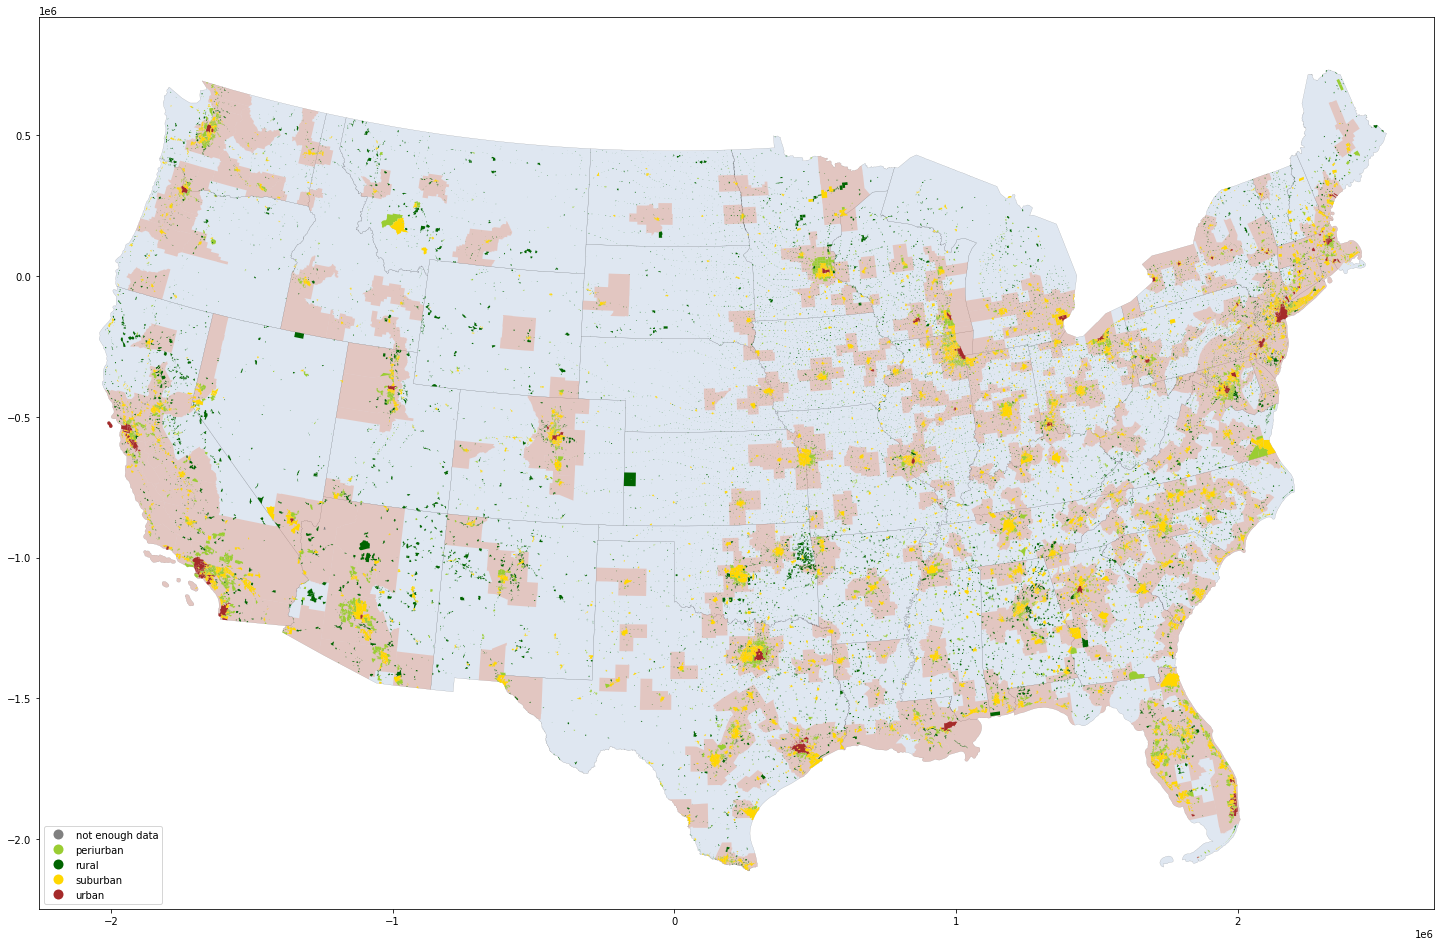

In [15]:
# to check if the intersected areas fall inside the MSAs
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,18))
US_states.plot(ax=ax, facecolor = 'lightsteelblue', edgecolor='black', linewidth=0.2, alpha = 0.4)
MSA_geo_20[MSA_geo_20['LSAD']=='M1'].plot(ax=ax, alpha = 0.4, color = 'darksalmon')

df.plot(ax= ax, column = 'city type', legend = True, legend_kwds={'loc': 'lower left'}, cmap = matplotlib.colors.ListedColormap(['grey', 'yellowgreen', 'darkgreen','gold','brown',])) 

xlim = ([-2257388.37, 2695859.75]) 
ylim = ([-2246944.04, 918095.9])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [16]:
# import and add median income for cities from ACS data
income_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S1901-Data.csv')
income_df = income_df[['GEO_ID', 'NAME', 'S1901_C01_012E']]
income_df = income_df.tail(-1).reset_index(drop = True)
income_df['GEOID'] = income_df['GEO_ID'].str[9:]
income_df.rename({'S1901_C01_012E':'median_income'}, axis =1, inplace = True)
df = df.merge(income_df[['median_income', 'GEOID']], on = 'GEOID')

# Income values with 2500- and 250,000+ is converted to numbers for str to float conversion
df['median_income'] = df['median_income'].replace('-', np.nan)
df['median_income'] = df['median_income'].replace('2,500-', '2499')
df['median_income'] = df['median_income'].replace('250,000+', '250001')
df['median_income'] = df['median_income'].astype(float)

C:\Users\uttar\AppData\Local\Temp\ipykernel_1384\2991260479.py:2: DtypeWarning: Columns (2,3,4,5,66,67,68,69,130,131,132,133,194,195,196,197) have mixed types. Specify dtype option on import or set low_memory=False.
  income_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S1901-Data.csv')


# Chart/graphs from analysis

In [17]:
# Replacing nan values in STATEFP with respective values from GEOID

df.loc[df['STATEFP'].isnull(),'STATEFP'] = df['GEOID'].str[:2]

# Replacing nan values in region with respective values for that region
df[df['REGION'].isnull()]['STATEFP'].unique()
# Northeast = []
Midwest = ['29', '46']
South = ['13', '21', '37', '40', '48', '54']
West = ['02', '04', '06', '08', '35', '49', '56'] 
        
df['REGION'] = np.where(df["STATEFP"].isin(Midwest), 2, df['REGION'])
df['REGION'] = np.where(df["STATEFP"].isin(South), 3, df['REGION'])
df['REGION'] = np.where(df["STATEFP"].isin(West), 4, df['REGION'])


In [18]:
for i in range(len(df)):
    # print(i)
    if df.loc[i,'REGION'] == 1:
        df.loc[i,'REGION'] = 'Northeast'
    elif df.loc[i,'REGION'] == 2:
        df.loc[i,'REGION'] = 'Midwest' 
    elif df.loc[i,'REGION'] == 3:
        df.loc[i,'REGION'] = 'South'
    elif df.loc[i,'REGION'] == 4:
        df.loc[i,'REGION'] = 'West'
    else:
        df.loc[i,'REGION'] = 'Outside Contiguous US'   

In [19]:
df['REGION'].value_counts()

South                    10504
Midwest                  10213
West                      6063
Northeast                 4816
Outside Contiguous US      292
Name: REGION, dtype: int64

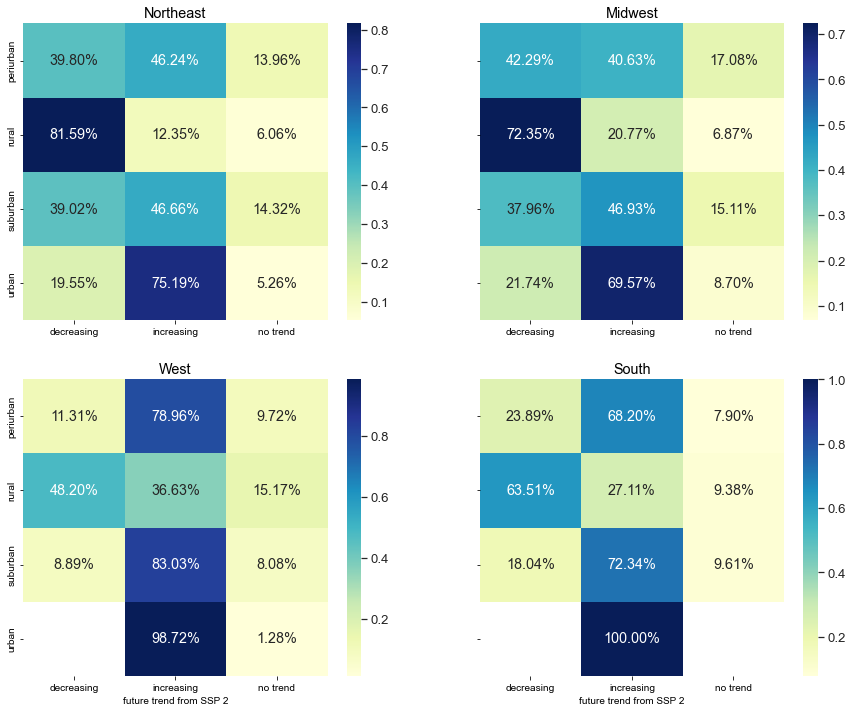

In [20]:
# Group the data by the three categorical variables and sum the values
trend_column = 'future trend from SSP 2'

grouped_data1 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Northeast')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data1 = grouped_data1.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data1 = hierarchical_data1.apply(lambda x: x/x.sum(), axis=1)

grouped_data2 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Midwest')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data2 = grouped_data2.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data2 = hierarchical_data2.apply(lambda x: x/x.sum(), axis=1)

grouped_data3 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'West')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data3 = grouped_data3.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data3 = hierarchical_data3.apply(lambda x: x/x.sum(), axis=1)

grouped_data4 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'South')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data4 = grouped_data4.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data4 = hierarchical_data4.apply(lambda x: x/x.sum(), axis=1)


fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
# fig.suptitle('Percent cities for different community type and Regions with their expected trend from SSP 2',)
sns.set(font_scale = 1.2)
# Bulbasaur
sns.heatmap(normalized_data1, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[0][0] , cbar_ax=None)
axes[0][0].set_title('Northeast')
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('')


sns.heatmap(normalized_data2, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[0][1] ,)
axes[0][1].set_title('Midwest')
axes[0][1].set_ylabel('')
axes[0][1].set_xlabel('')


sns.heatmap(normalized_data3, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[1][0] , )
axes[1][0].set_title('West')
axes[1][0].set_ylabel('')

sns.heatmap(normalized_data4, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[1][1] , )
axes[1][1].set_title('South')
axes[1][1].set_ylabel('')

fig.savefig('D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\Trend with DoU_' + str(trend_column) + '.png', 
            dpi = 300, bbox_inches='tight')

In [21]:
df[(df['trend'] == 'decreasing') & (df['REGION'] == 'Midwest')][['STATEFP', 'GEOID', 'NAMELSAD', 'CensusPop_20', 'city type',
                                                                 'trend', 'future trend from SSP 1',
                                                                 'future trend from SSP 2']].sort_values(['CensusPop_20',]).tail(10)

,STATEFP,GEOID,NAMELSAD,CensusPop_20,city type,trend,future trend from SSP 1,future trend from SSP 2
6506,17,1779293,Waukegan city,89321.0,suburban,decreasing,decreasing,decreasing
12736,26,2649000,Livonia city,95535.0,suburban,decreasing,decreasing,decreasing
12587,26,2621000,Dearborn city,109976.0,suburban,decreasing,decreasing,decreasing
20545,39,3921000,Dayton city,137644.0,suburban,decreasing,decreasing,decreasing
6773,17,1765000,Rockford city,148655.0,suburban,decreasing,decreasing,decreasing
20794,39,3901000,Akron city,190469.0,suburban,decreasing,increasing,increasing
20758,39,3977000,Toledo city,270871.0,suburban,decreasing,decreasing,decreasing
15390,29,2965000,St. Louis city,301578.0,urban,decreasing,increasing,increasing
20970,39,3916000,Cleveland city,372624.0,urban,decreasing,decreasing,decreasing
12590,26,2622000,Detroit city,639111.0,urban,decreasing,decreasing,decreasing


In [22]:
crosstabRes = pd.crosstab(index = df['city type'], columns = df['label'])
from scipy.stats import chi2_contingency
chisqRes =  chi2_contingency(crosstabRes)
print('P-value of the chi- squared test: ', chisqRes[1])
if chisqRes[1] < 0.05:
    print('The variables have correlation.')
else:
    print('not correlated')

P-value of the chi- squared test:  0.0
The variables have correlation.


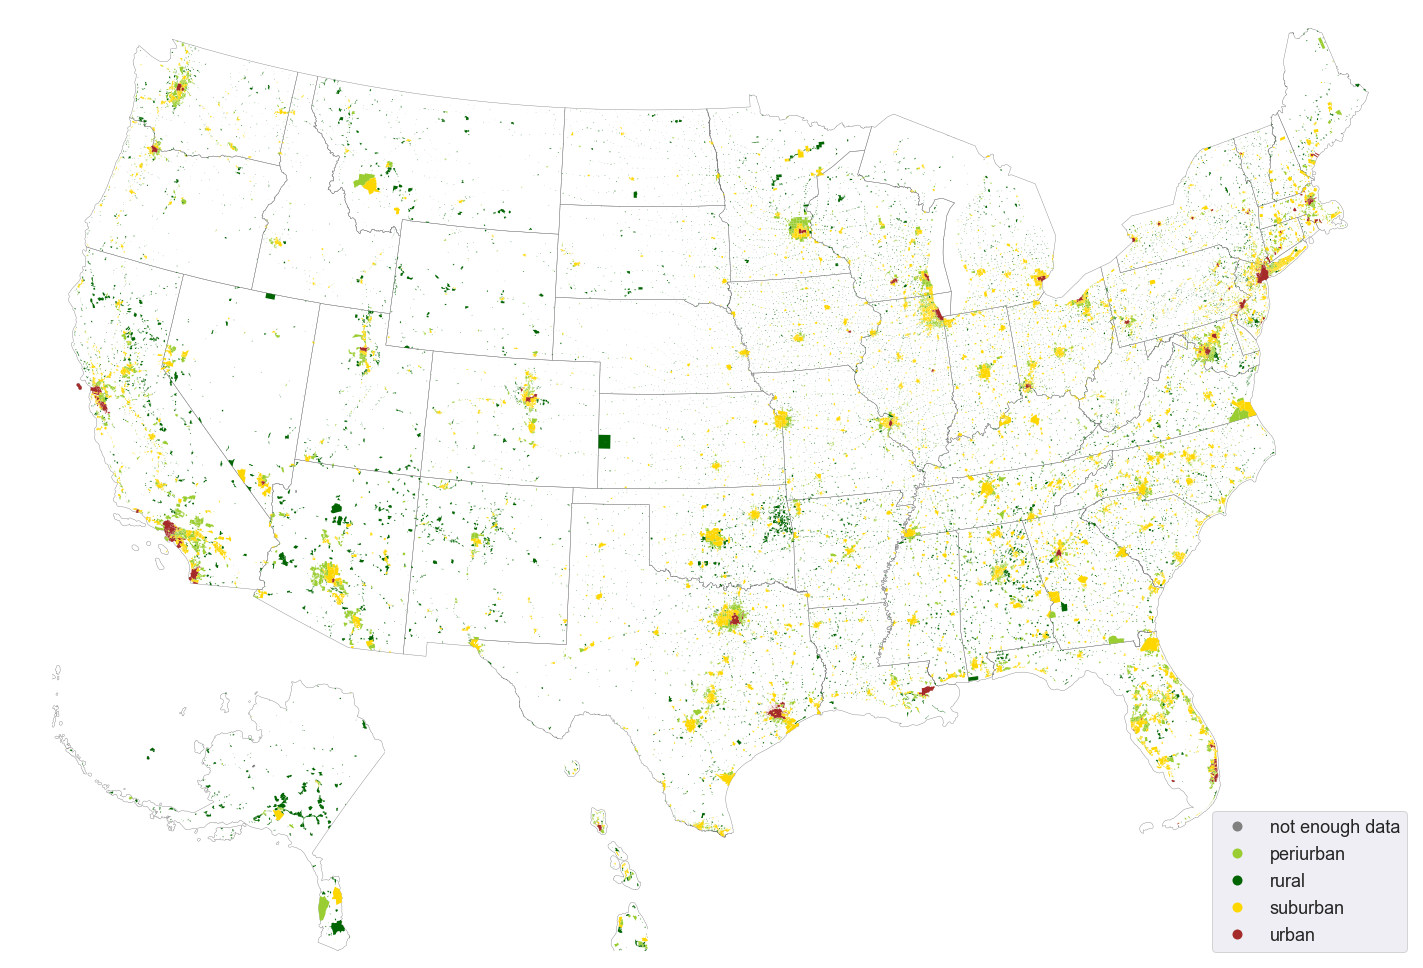

In [23]:
col = "city type"
cmap_color = matplotlib.colors.ListedColormap(['grey', 'yellowgreen', 'darkgreen','gold','brown',])

fig, continental_ax = plt.subplots(figsize=(20, 20))
alaska_ax = continental_ax.inset_axes([.01, .01, .28, .30])
hawaii_ax = continental_ax.inset_axes([.30, .01, .25, .20])

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2546944.04, 808080.9)

alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)   # bounds found for only populated places in Hawaii
hawaii_ax.set_ylim(-1044618.58269969, -455238.37803499)

# Plot the data per area - requires passing the same choropleth parameters to each call
# because different data is used in each call, so automatically setting bounds won’t work
#vmin, vmax = df['ALAND'].agg(['min', 'max'])
US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
df.plot(column=col, 
        ax=continental_ax,
        cmap=cmap_color,
        edgecolor = 'None',
        alpha = 1,
        legend = True,
        legend_kwds={'loc': 'lower right', 'fontsize': 18,}) #, vmin=vmin, vmax=vmax)

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.4, ax=alaska_ax)
df.plot(column=col, cmap=cmap_color, edgecolor = 'None', ax=alaska_ax) #, vmin=vmin, vmax=vmax)
US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.4, ax=hawaii_ax)
df.plot(column=col, cmap=cmap_color, edgecolor = 'None', ax=hawaii_ax) #, vmin=vmin, vmax=vmax)

# continental_ax.set_title('TITLE', fontsize=15, pad=5) 
#from ACS 5-yr population estimates using data from 2010-2020, (b) 

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    plt.tight_layout()
    plt.axis('off') 
        
fig.patch.set_visible(False)
    
    
fig.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\urban_rural_continuum' + '.png', dpi = 300,
           bbox_inches='tight')

(-430006.06386062, -352453.50247821)

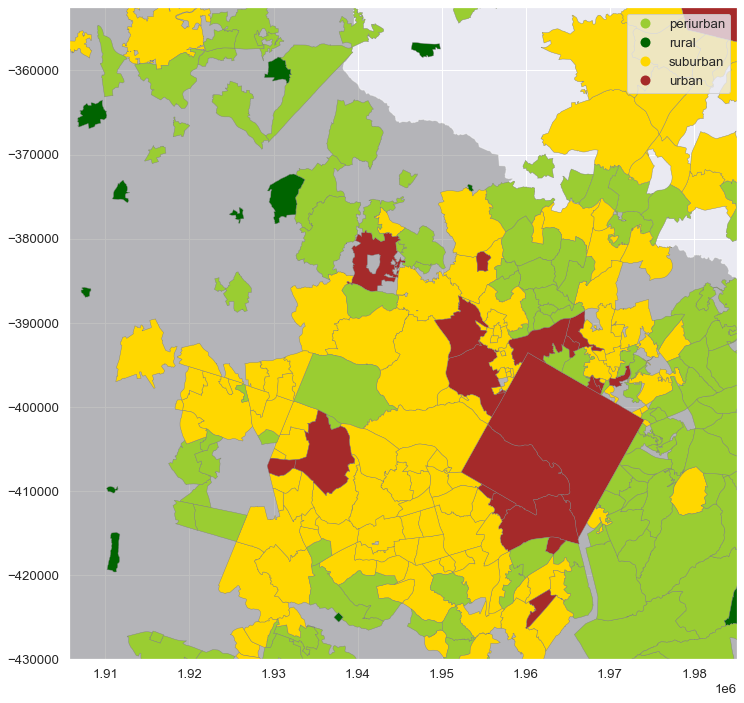

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,12))
cmap_color = matplotlib.colors.ListedColormap(['yellowgreen', 'darkgreen','gold','brown',])
MSA_geo_20[MSA_geo_20['NAMELSAD'].str.contains('DC')].plot(ax=ax, alpha = 0.5, color = 'gray') # [MSA_data_20['LSAD']=='M1']
df[(df['STATEFP'] == '11') | (df['STATEFP'] == '24') | (df['STATEFP'] == '51')].plot(ax= ax, cmap=cmap_color, column  = 'city type', 
                                                                                     edgecolor='gray', linewidth=0.4, legend = True)
xlim = ([1905651.2601596, 1985109.28733622]) 
ylim = ([-430006.06386062,-352453.50247821])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [25]:
df['veh_<=_1'] = df[['no_veh', 'veh_1']].sum(axis=1)
df['veh 1+'] = df[['veh_1', 'veh_2_or+']].sum(axis=1)

df[['STATEFP', 'GEOID', 'NAMELSAD','weighted_HU_density_sqmi', 'P_20', 'label', 'density_km2',
       'Pop_estimate', 'CensusPop_20', 'trend', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 'REGION',
       'DIVISION', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2_or+',
       'GEOID_place', 'GEOID_cbsa', 'cbsa20-to-place allocation factor',
       'tt_2_work', 'GEOID_', 'Urban area (2022)_count',
       'population_place_sum', 'ua-to-place allocation factor_min',
       'ua-to-place allocation factor_max', 'population_ua_min',
       'population_ua_max', 'city type', 'median_income', 'veh 1+',
       'veh_<=_1']].to_csv(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\df_attributes.csv')


# Vehicle ownership vs REGION→Trend

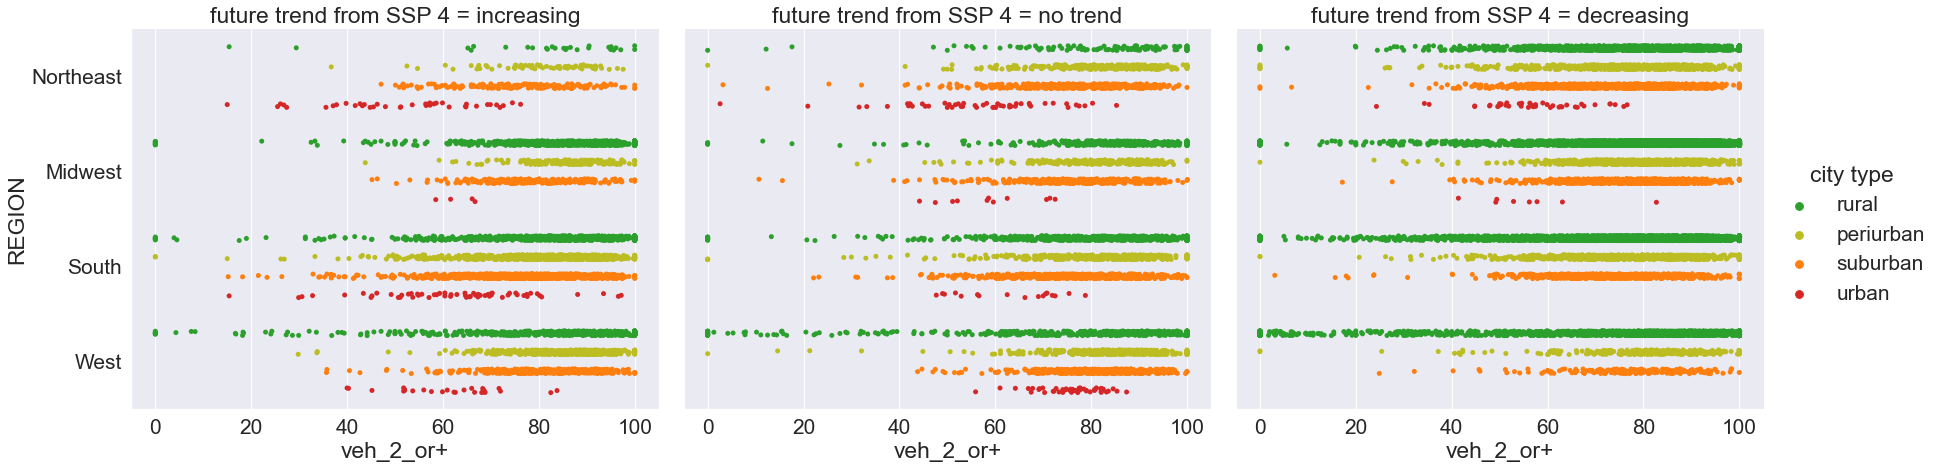

In [26]:
df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] != 'Outside Contiguous US')]
df_plot
trend_column = "future trend from SSP 4"
sns.set(font_scale = 1.9)
g = sns.catplot(
    data=df_plot, y="REGION", x='veh_2_or+', col=trend_column, hue = 'city type', col_wrap =3,
    order=['Northeast', 'Midwest', 'South', 'West'],
    kind="strip", dodge = True, height=7, aspect= 1.2, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
    palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'],
    col_order = ['increasing', 'no trend', 'decreasing']
)


# Median income vs REGION→Trend

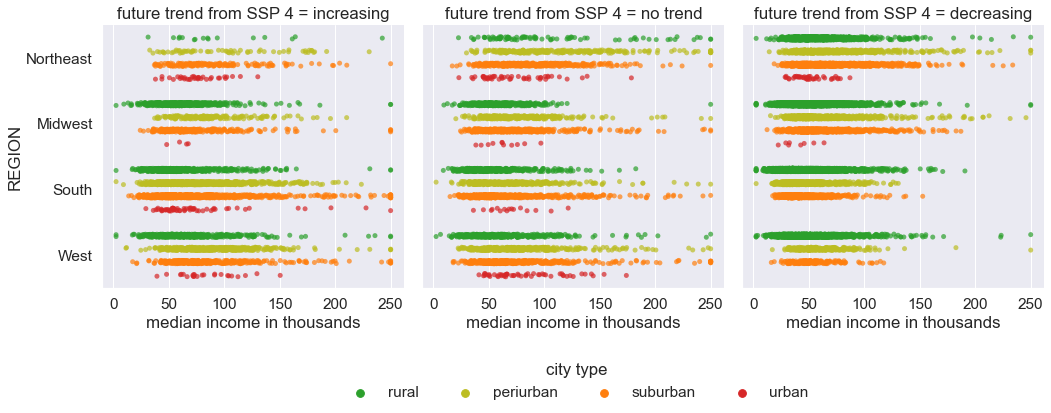

In [27]:
trend_col = 'future trend from SSP 4'
df_scatter = df[['median_income', 'CensusPop_20', 'density_km2', 'city type', 'REGION', trend_col,]].dropna()
df_scatter = df_scatter[(df_scatter['REGION'] != 'Outside Contiguous US') & (df_scatter['density_km2'] < 15000)]
df_scatter['median income in thousands'] = df_scatter['median_income']/1000
df_scatter.dtypes

sns.set(font_scale = 1.4)
g = sns.catplot(data=df_scatter, x='median income in thousands', y = 'REGION', alpha =0.7,
            order=['Northeast', 'Midwest', 'South', 'West'],
            col_order = ['increasing', 'no trend', 'decreasing'],
            hue_order= ['rural', 'periurban', 'suburban', 'urban'],
            palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'],
            hue="city type", dodge=True, col=trend_col,
           )

sns.move_legend(g, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5, frameon=False)
# plt.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.20),
#           fancybox=True, shadow=True, ncol=4)
plt.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\trend_vs_median_income' + str(trend_col) +'.png', 
            dpi =300, bbox_inches = 'tight')

<AxesSubplot:>

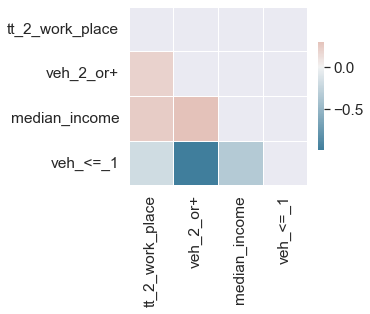

In [28]:
# Compute the correlation matrix
corr = df[['tt_2_work_place', 'veh_2_or+', 'median_income', 'veh_<=_1']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
